In [1]:
%config InlineBackend.figure_format = 'retina'
import numpy as np
import sys
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from operator import itemgetter
import lmfit
from scipy import signal
from scipy import fftpack
from skimage import util
import operator
from numpy import NaN, Inf, arange, isscalar, asarray, array
import pylab
import inspect

run = ['001','002','003','004','005','006','007','008','009','010',
       '011','012','013','014','015','016','017','018','019','020', 
       '021','022','023','024','025','026','027','028','029','030',
       '031','032','033','034','035','036','037','038','039','040',
       '041','042','043','044','045','046','047','048','049','050',
       '051','052','053','054','055','056','057','058','059','060',
       '061','062','063','064','065','066','067','068','069','070',
       '071','072','073','074','075','076','077','078','079','080',
       '081','082','083','084','085','086','087','088','089','090',
       '091','092','093','094','095','096','097','098','099','100',
       '101','102','103','104','105','106','107','108','109','110',
       '111','112','113','114','115','116','117','118','119','120', 
       '121','122','123','124','125','126','127','128','129','130',
       '131','132','133','134','135','136','137','138','139','140',
       '141','142','143','144','145','146','147','148','149','150',
       '151','152','153','154','155','156','157','158','159','160',
       '161','162','163','164','165','166','167','168','169','170',
       '171','172','173','174','175','176','177','178','179','180',
       '181','182','183','184','185','186','187','188','189','190',
       '191','192','193','194','195','196','197','198','199','200',
       '201','202','203','204','205','206','207','208','209','210',
       '211','212','213','214','215','216']
kx_ind = [0.0125,  0.0150,  0.0175,  0.0200,  0.0225,  0.0250,  0.0275,  0.0300,  0.0325,  0.0350,
          0.0375,  0.0400,  0.0425,  0.0450,  0.0475,  0.0500,  0.1000,  0.2000,  0.3000,  0.4000,
          0.5000,  0.6000,  0.7000,  0.8000,  0.9000,  1.0000,  1.1000,  1.2000,  1.3000,  1.4000,
          1.5000,  1.6000,  1.7000,  1.8000,  1.9000,  2.0000]

##############################################################################################################
###############################################    FUNCTIONS     #############################################
##############################################################################################################


#############################################    PEAK DETECTOR     ###########################################

def peakdet(v, delta, x = None):
    maxtab = []
    mintab = []
       
    if x is None:
        x = arange(len(v))
    
    v = asarray(v)
    
    if len(v) != len(x):
        sys.exit('Input vectors v and x must have same length')
    
    if not isscalar(delta):
        sys.exit('Input argument delta must be a scalar')
    
    if delta <= 0:
        sys.exit('Input argument delta must be positive')
    
    mn, mx = Inf, -Inf
    mnpos, mxpos = NaN, NaN
    
    lookformax = True
    
    for i in arange(len(v)):
        this = v[i]
        if this > mx:
            mx = this
            mxpos = x[i]
        if this < mn:
            mn = this
            mnpos = x[i]
        
        if lookformax:
            if this < mx-delta:
                maxtab.append((mxpos, mx))
                mn = this
                mnpos = x[i]
                lookformax = False
        else:
            if this > mn+delta:
                mintab.append((mnpos, mn))
                mx = this
                mxpos = x[i]
                lookformax = True

    return array(maxtab), array(mintab)

#############################################    FITTING MODEL     ###########################################

def model(t, decay):  # , omega, resid):
    return np.exp(-t/decay)  # * np.cos(omega * t) + resid
gmodel = lmfit.Model(model)

#############################################    DIAGNOSTIC TOOL     ###########################################

def diag_w7x(filename, minlim=None, maxlim=None, spectrogram=False, plot=False, my_data=None, k=None, Lx=None, nkx0=None):
    
    kx_ind = np.linspace((3.1415*2/Lx), (3.1415*2/Lx)*((nkx0//2)), (nkx0//2))
    
    if maxlim is not None and minlim is None:
        nummy = run[0:maxlim]
        if k is not None:
            kx = kx_ind[k:(maxlim+k)]
        else:
            kx = kx_ind[0:maxlim]
    elif minlim is not None and maxlim is None:
        nummy = run[minlim:len(run)]
        kx = kx_ind[minlim:len(run)]
    elif minlim is not None and maxlim is not None:
        nummy = run[minlim:maxlim]
        if k is not None:
            kx = kx_ind[(k+minlim):(maxlim+k)]
        else:
            kx = kx_ind[minlim:maxlim]
    if minlim is None and maxlim is None:
        nummy = run
        kx = kx_ind   
    

    dataset = [('./{0}/GAMDIAGions_0{1}.dat'.format(filename, index), index) for index in nummy]     
    datalist = [ ( pylab.loadtxt(datapath), label) for datapath, label in dataset]  # Load the .dat files as an array

    if plot == True and type(my_data) == type(None):
        plt.figure(figsize=(13, 6.5))
        plt.axhline(y=0, color='black', linestyle='dashed')
        plt.title("{0}".format(filename), fontsize=30)
        #plt.xscale('log')
        plt.xlabel('Time ($a / v_{ti}$)',fontsize=19)
        plt.ylabel('$\phi (t) / \phi (0)$',fontsize=19)
    
    if type(my_data) == type(None):
        integ = []
        rmsvl = []
        decay = []
        osrat = []
        burat = []
        g1rat = []
        g2rat = []
        dcrat = []
        perid = []
        perbd = []
        pekti = []
    else:
        integ = my_data[0, :].tolist()
        rmsvl = my_data[1, :].tolist()
        decay = my_data[2, :].tolist()
        osrat = my_data[3, :].tolist()
        burat = my_data[4, :].tolist()
        g1rat = my_data[5, :].tolist()
        g2rat = my_data[6, :].tolist()
        dcrat = my_data[7, :].tolist()
        perid = my_data[8, :].tolist()
        perbd = my_data[9, :].tolist()
        pekti = my_data[10, :].tolist()
            
    for data, label in datalist:
        E = (data[:,1]*(1/data[0, 1]))
        t = data[:,0]
        
        if plot == True:
            plt.plot(t, E, label='{0}'.format(label))
            if len(nummy) < 11:
                plt.legend(kx, title='$k_{x}$', fontsize=14)
                plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        intefield = np.trapz(E, t)
        integ.append(intefield)
        rms = np.sqrt(np.mean(E**2))
        rmsvl.append(rms)
        
        result, OS, BR, GR1, GR2, DR, PE, PE2, TP = nucleus_w7x(E, t, label, diag=False)   
        
        decay.append(result.best_values.get('decay'))
        osrat.append(OS)
        burat.append(BR)
        g1rat.append(GR1)
        g2rat.append(GR2)
        dcrat.append(DR)
        perid.append(PE)
        perbd.append(PE2)
        pekti.append(TP)
    
        if spectrogram == True:
            ########  SPECTROGRAM
            f_s = len(data[:, 0]) / data[-1, 0]
            E = (data[:,1]*(1/data[0, 1]))
            M = 1024
            slices = util.view_as_windows(E, window_shape=(M,), step=2)
            win = np.hanning(M + 1)[:-1]
            slices = slices * win
            slices = slices.T
            spectrum = np.fft.fft(slices, axis=0)[:M // 2 + 1:-1]
            spectrum = np.abs(spectrum)
            S = np.abs(spectrum)
            S = 20 * np.log10(S / np.max(S))
            plt.figure()
            plt.imshow(S, origin='lower', cmap='viridis')
            plt.title(str(label), fontsize=30)
            plt.axis('tight')
            plt.ylabel('Frequency [Hz]')
            plt.xlabel('Time ($a / v_{ti}$)')
            #plt.ylim([0, 0.3])

    f_s = len(data[:, 0]) / data[-1, 0]
    my_data = np.array([integ, rmsvl, decay, osrat, burat, g1rat, g2rat, dcrat, perid, perbd, pekti])
    return kx, my_data, E, t, f_s, label

#############################################    DIAGNOSTIC PLOTTER     ###########################################

def retrieve_name(var):
        """
        Gets the name of var. Does it from the out most frame inner-wards.
        :param var: variable to get name from.
        :return: string
        """
        for fi in reversed(inspect.stack()):
            names = [var_name for var_name, var_val in fi.frame.f_locals.items() if var_val is var]
            if len(names) > 0:
                return names[0]

def diag_plotter(kx, my_data, alldata=False, fig=True):
    
    integ = my_data[0, :]
    rmsvl = my_data[1, :]
    decay = my_data[2, :]
    osrat = my_data[3, :]
    burat = my_data[4, :]
    g1rat = my_data[5, :]
    g2rat = my_data[6, :]
    dcrat = my_data[7, :]
    perid = my_data[8, :]
    perbd = my_data[9, :]
    pekti = my_data[10, :]
    
    if fig == True:
        fig = plt.figure(figsize=(30, 20))
    else:
        fig = fig
        
    ax1 = fig.add_subplot(331)
    ax2 = fig.add_subplot(332)
    ax3 = fig.add_subplot(333)
    ax4 = fig.add_subplot(334)
    ax5 = fig.add_subplot(335)
    ax6 = fig.add_subplot(336)
    ax7 = fig.add_subplot(337)
    ax8 = fig.add_subplot(338)
    ax9 = fig.add_subplot(339)


    ########  top
    ax1.plot(kx, integ)
    ax2.plot(kx, rmsvl)
    ax3.plot(kx, decay)
    
    #ax1.set_xlabel('$k_{x} \\rho_{ti}$')
    #ax2.set_xlabel('$k_{x} \\rho_{ti}$')
    #ax3.set_xlabel('$k_{x} \\rho_{ti}$')

    ax1.title.set_text('Integral')
    ax2.title.set_text('RMS value')
    ax3.title.set_text('Decay length')

    ########  mid
    ax4.plot(kx, osrat)
    ax5.plot(kx, g2rat, label='Growth ratio')
    ax5.plot(kx, dcrat, label='Decay ratio')
    ax6.plot(kx, pekti, label='{0}'.format(retrieve_name(my_data)))
    
    #ax4.set_xlabel('$k_{x} \\rho_{ti}$')
    #ax5.set_xlabel('$k_{x} \\rho_{ti}$')
    #ax6.set_xlabel('$k_{x} \\rho_{ti}$')
    
    ax4.title.set_text('Overshoot ratio')
    # ax5.title.set_text('')
    ax6.title.set_text('Peak time')
    ax6.legend(loc="upper right")
    ax5.legend(loc="lower right")
    
    ########  bottom
    #ax3.title.set_text('RMS')
    ax7.plot(kx, g1rat)
    ax8.plot(kx, burat)
    ax9.plot(kx, perid, label='Decay Period')
    ax9.plot(kx, perbd, label='Bump Period')
    
    ax7.title.set_text('Bump growth ratio')
    ax8.title.set_text('Bump ratio')
    # ax9.title.set_text('Period')
    ax9.legend(loc="upper right")
    
    ax7.set_xlabel('$k_{x} \\rho_{ti}$')
    ax8.set_xlabel('$k_{x} \\rho_{ti}$')
    ax9.set_xlabel('$k_{x} \\rho_{ti}$')

    if alldata == False:
        fig.show()

    return fig
#############################################    TROUBLESHOOTER     #############################################
def troubleshooter(E, t, f_s, label, spectrogram=True):
    
    X = fftpack.fft(E)
    freqs = fftpack.fftfreq(len(E)) * f_s

    f, (ax2) = plt.subplots(1, 1, figsize=(15, 5))
    #ax1.stem(freqs, np.abs(X))
    #ax1.set_xlabel('Frequency in Hertz [Hz]')
    #ax1.set_ylabel('Frequency Domain (Spectrum) Magnitude')
    #ax1.set_xlim(0, f_s / 2)
    #ax2.set_ylim(-2, 2)
    ax2.set_xlim(0, 500)
    ax2.plot(t, E, label='{0}'.format(label))
    ax2.axhline(y=0, color='black', linestyle='dashed')
    
    maxtab, mintab, OS, BR, GR1, GR2, DR, PE, PE2, TP, a, b1, b2, e, i, o = nucleus_w7x(E, t, label, diag=True)
    
    if type(b1) == float and type(o) != float:
        n = ['a', 'e', 'i', 'o']
        x = np.array([a, e, i, o])[:,1]
        y = np.array([a, e, i, o])[:,0]
    elif type(b1) != float and type(o) == float:
        n = ['a', 'b1', 'b2', 'e', 'i']
        x = np.array([a, b1, b2, e, i])[:,1]
        y = np.array([a, b1, b2, e, i])[:,0]
    else:
        n = ['a', 'b1', 'b2', 'e', 'i', 'o']
        x = np.array([a, b1, b2, e, i, o])[:,1]
        y = np.array([a, b1, b2, e, i, o])[:,0]
    ax2.scatter(y,x, color='blue')
    for r, txt in enumerate(n):
        ax2.annotate(txt, (y[r], x[r]))
    ax2.scatter(maxtab[:, 0], maxtab[:, 1], color='red')
    ax2.scatter(mintab[:, 0], mintab[:, 1], color='blue')
    ax2.scatter(e[0], e[1], color='green')
    print('Overshoot ratio (OS): ' + str(OS))
    print('Bump ratio (BR): ' + str(BR))
    print('Bump growth ratio (GR1): ' + str(GR1))
    print('2nd growth ratio (GR2): ' + str(GR2))
    print('Period (PE): ' + str(PE))
    print('Peak time (TP): ' + str(TP))
    
    if spectrogram == True:
            ########  SPECTROGRAM
            M = 1024
            slices = util.view_as_windows(E, window_shape=(M,), step=2)
            win = np.hanning(M + 1)[:-1]
            slices = slices * win
            slices = slices.T
            spectrum = np.fft.fft(slices, axis=0)[:M // 2 + 1:-1]
            spectrum = np.abs(spectrum)
            S = np.abs(spectrum)
            S = 20 * np.log10(S / np.max(S))
            plt.figure(figsize=(13, 6.5))
            plt.imshow(S, origin='lower', cmap='viridis')
            plt.title(str(label), fontsize=30)
            plt.axis('tight')
            plt.ylabel('Frequency [Hz]')
            plt.xlabel('Time ($a / v_{ti}$)')
            #plt.ylim([0, 0.3])
    
    return 
    

In [3]:
subset = run
dataset = [('./w7x-hm/GAMDIAGions_0{0}.dat'.format(index), index) for index in subset] # Change here geometry
datalist = [ ( pylab.loadtxt(datapath), label) for datapath, label in dataset]  # Load the .dat files as an array
figure(figsize=(13, 6.5))

for data, label in datalist:
    pylab.plot( data[:,0], (data[:,1]*(1/data[0, 1])), label='{0}'.format(label))  # Change the index of 2nd data to 2 and plot the imaginary part

pylab.axhline(y=0, color='black', linestyle='dashed')
#pylab.legend(subset, title='$k_{x}$', fontsize=14)
#pylab.title("Title of Plot")
#pylab.ylim([-0.2, 0.3])
pylab.xlabel('Time ($a / v_{ti}$)',fontsize=19)
pylab.ylabel('$\phi (t) / \phi (0)$',fontsize=19)

zf_integral_wh = []
for data, label in datalist:
    intefield = np.trapz((data[:,1]*(1/data[0, 1])), data[:, 0])
    zf_integral_wh.append(intefield)
plt.figure()
plt.plot(kxc, zf_integral_wh)
plt.yscale('log')
plt.show()

OSError: ./w7x-hm/GAMDIAGions_0001.dat not found.

In [ ]:
sliced = itemgetter(1, 2 ,3)(nummy)  # Introduce the values you want to plot
subset = nummy
dataset = [('./w7x-hm_l/GAMDIAGions_0{0}.dat'.format(index), index) for index in subset] # Change here geometry
datalist = [ ( pylab.loadtxt(datapath), label) for datapath, label in dataset]  # Load the .dat files as an array
figure(figsize=(13, 6.5))

for data, label in datalist:
    pylab.plot( data[:,0], (data[:,1]*(1/data[0, 1])), label='{0}'.format(label))  # Change the index of 2nd data to 2 and plot the imaginary part

pylab.axhline(y=0, color='black', linestyle='dashed')
#pylab.legend(subset, title='$k_{x}$', fontsize=14)
#pylab.title("Title of Plot")
#pylab.ylim([-0.2, 0.3])
pylab.xlabel('Time ($a / v_{ti}$)',fontsize=19)
pylab.ylabel('$\phi (t) / \phi (0)$',fontsize=19)

zf_integral_whl = []
for data, label in datalist:
    intefield = np.trapz((data[:,1]*(1/data[0, 1])), data[:, 0])
    zf_integral_whl.append(intefield)
plt.figure()
plt.plot(kxc, zf_integral_whl)
plt.yscale('log')
plt.show()

In [ ]:
sliced = itemgetter(1, 2 ,3)(nummy)  # Introduce the values you want to plot
subset = nummy
dataset = [('./w7x-sc/GAMDIAGions_0{0}.dat'.format(index), index) for index in subset] # Change here geometry
datalist = [ ( pylab.loadtxt(datapath), label) for datapath, label in dataset]  # Load the .dat files as an array
figure(figsize=(13, 6.5))

for data, label in datalist:
    pylab.plot( data[:,0], (data[:,1]*(1/data[0, 1])), label='{0}'.format(label))  # Change the index of 2nd data to 2 and plot the imaginary part

pylab.axhline(y=0, color='black', linestyle='dashed')
#pylab.legend(subset, title='$k_{x}$', fontsize=14)
#pylab.title("Title of Plot")
#pylab.ylim([-0.2, 0.3])
pylab.xlabel('Time ($a / v_{ti}$)',fontsize=19)
pylab.ylabel('$\phi (t) / \phi (0)$',fontsize=19)

zf_integral_ws = []
for data, label in datalist:
    intefield = np.trapz((data[:,1]*(1/data[0, 1])), data[:, 0])
    zf_integral_ws.append(intefield)
plt.figure()
plt.plot(kxc, zf_integral_ws)
plt.yscale('log')
plt.show()

In [ ]:
sliced = itemgetter(1, 2 ,3)(nummy)  # Introduce the values you want to plot
subset = nummy
dataset = [('./w7x-sc_l/GAMDIAGions_0{0}.dat'.format(index), index) for index in subset] # Change here geometry
datalist = [ ( pylab.loadtxt(datapath), label) for datapath, label in dataset]  # Load the .dat files as an array
figure(figsize=(13, 6.5))

for data, label in datalist:
    pylab.plot( data[:,0], (data[:,1]*(1/data[0, 1])), label='{0}'.format(label))  # Change the index of 2nd data to 2 and plot the imaginary part

pylab.axhline(y=0, color='black', linestyle='dashed')
#pylab.legend(subset, title='$k_{x}$', fontsize=14)
#pylab.title("Title of Plot")
#pylab.ylim([-0.2, 0.3])
#pylab.xlim([0.0, 200.0])
pylab.xlabel('Time ($a / v_{ti}$)',fontsize=19)
pylab.ylabel('$\phi (t) / \phi (0)$',fontsize=19)

zf_integral_wsl = []
for data, label in datalist:
    intefield = np.trapz((data[:,1]*(1/data[0, 1])), data[:, 0])
    zf_integral_wsl.append(intefield)
plt.figure()
plt.plot(kxc, zf_integral_wsl)
plt.yscale('log')
plt.show()

In [ ]:
sliced = itemgetter(1, 2 ,3)(nummy)  # Introduce the values you want to plot
subset = nummy
dataset = [('./hsx/GAMDIAGions_0{0}.dat'.format(index), index) for index in subset] # Change here geometry
datalist = [ ( pylab.loadtxt(datapath), label) for datapath, label in dataset]  # Load the .dat files as an array
figure(figsize=(13, 6.5))

for data, label in datalist:
    pylab.plot( data[:,0], (data[:,1]*(1/data[0, 1])), label='{0}'.format(label))  # Change the index of 2nd data to 2 and plot the imaginary part

pylab.axhline(y=0, color='black', linestyle='dashed')
#pylab.legend(subset, title='$k_{x}$', fontsize=14)
#pylab.title("Title of Plot")
#pylab.ylim([-0.2, 0.3])
pylab.xlabel('Time ($a / v_{ti}$)',fontsize=19)
pylab.ylabel('$\phi (t) / \phi (0)$',fontsize=19)

zf_integral_h = []
for data, label in datalist:
    intefield = np.trapz((data[:,1]*(1/data[0, 1])), data[:, 0])
    zf_integral_h.append(intefield)
plt.figure()
plt.plot(kxc, zf_integral_h)
plt.yscale('log')
plt.show()

In [ ]:
sliced = itemgetter(1, 2 ,3)(nummy)  # Introduce the values you want to plot
subset = nummy
dataset = [('./hsx_l/GAMDIAGions_0{0}.dat'.format(index), index) for index in subset] # Change here geometry
datalist = [ ( pylab.loadtxt(datapath), label) for datapath, label in dataset]  # Load the .dat files as an array
figure(figsize=(13, 6.5))

for data, label in datalist:
    pylab.plot( data[:,0], (data[:,1]*(1/data[0, 1])), label='{0}'.format(label))  # Change the index of 2nd data to 2 and plot the imaginary part

pylab.axhline(y=0, color='black', linestyle='dashed')
#pylab.legend(subset, title='$k_{x}$', fontsize=14)
#pylab.title("Title of Plot")
#pylab.ylim([-0.2, 0.3])
pylab.xlabel('Time ($a / v_{ti}$)',fontsize=19)
pylab.ylabel('$\phi (t) / \phi (0)$',fontsize=19)

zf_integral_hl = []
for data, label in datalist:
    intefield = np.trapz((data[:,1]*(1/data[0, 1])), data[:, 0])
    zf_integral_hl.append(intefield)
plt.figure()
plt.plot(kxc, zf_integral_hl)
plt.yscale('log')
plt.show()

In [ ]:
sliced = itemgetter(1, 2 ,3)(nummy)  # Introduce the values you want to plot
subset = nummy
dataset = [('./lhd-b/GAMDIAGions_0{0}.dat'.format(index), index) for index in subset] # Change here geometry
datalist = [ ( pylab.loadtxt(datapath), label) for datapath, label in dataset]  # Load the .dat files as an array
figure(figsize=(13, 6.5))

for data, label in datalist:
    pylab.plot( data[:,0], (data[:,1]*(1/data[0, 1])), label='{0}'.format(label))  # Change the index of 2nd data to 2 and plot the imaginary part

pylab.axhline(y=0, color='black', linestyle='dashed')
#pylab.legend(subset, title='$k_{x}$', fontsize=14)
#pylab.title("Title of Plot")
#pylab.ylim([-0.2, 0.3])
pylab.xlabel('Time ($a / v_{ti}$)',fontsize=19)
pylab.ylabel('$\phi (t) / \phi (0)$',fontsize=19)

zf_integral_lb = []
for data, label in datalist:
    intefield = np.trapz((data[:,1]*(1/data[0, 1])), data[:, 0])
    zf_integral_lb.append(intefield)
plt.figure()
plt.plot(kxc, zf_integral_lb)
plt.yscale('log')
plt.show()

In [ ]:
sliced = itemgetter(1, 2 ,3)(nummy)  # Introduce the values you want to plot
subset = nummy
dataset = [('./lhd-b_l/GAMDIAGions_0{0}.dat'.format(index), index) for index in subset] # Change here geometry
datalist = [ ( pylab.loadtxt(datapath), label) for datapath, label in dataset]  # Load the .dat files as an array
figure(figsize=(13, 6.5))

for data, label in datalist:
    pylab.plot( data[:,0], (data[:,1]*(1/data[0, 1])), label='{0}'.format(label))  # Change the index of 2nd data to 2 and plot the imaginary part

pylab.axhline(y=0, color='black', linestyle='dashed')
#pylab.legend(subset, title='$k_{x}$', fontsize=14)
#pylab.title("Title of Plot")
#pylab.ylim([-0.2, 0.3])
pylab.xlabel('Time ($a / v_{ti}$)',fontsize=19)
pylab.ylabel('$\phi (t) / \phi (0)$',fontsize=19)

zf_integral_lbl = []
for data, label in datalist:
    intefield = np.trapz((data[:,1]*(1/data[0, 1])), data[:, 0])
    zf_integral_lbl.append(intefield)
plt.figure()
plt.plot(kxc, zf_integral_lbl)
plt.yscale('log')
plt.show()

In [ ]:
sliced = itemgetter(1, 2 ,3)(nummy)  # Introduce the values you want to plot
subset = nummy
dataset = [('./lhd-p/GAMDIAGions_0{0}.dat'.format(index), index) for index in subset] # Change here geometry
datalist = [ ( pylab.loadtxt(datapath), label) for datapath, label in dataset]  # Load the .dat files as an array
figure(figsize=(13, 6.5))

for data, label in datalist:
    pylab.plot( data[:,0], (data[:,1]*(1/data[0, 1])), label='{0}'.format(label))  # Change the index of 2nd data to 2 and plot the imaginary part

pylab.axhline(y=0, color='black', linestyle='dashed')
#pylab.legend(subset, title='$k_{x}$', fontsize=14)
#pylab.title("Title of Plot")
#pylab.ylim([-0.2, 0.3])
pylab.xlabel('Time ($a / v_{ti}$)',fontsize=19)
pylab.ylabel('$\phi (t) / \phi (0)$',fontsize=19)

zf_integral_lp = []
for data, label in datalist:
    intefield = np.trapz((data[:,1]*(1/data[0, 1])), data[:, 0])
    zf_integral_lp.append(intefield)
plt.figure()
plt.plot(kxc, zf_integral_lp)
plt.yscale('log')
plt.show()

In [ ]:
sliced = itemgetter(1, 2 ,3)(nummy)  # Introduce the values you want to plot
subset = nummy
dataset = [('./lhd-p_l/GAMDIAGions_0{0}.dat'.format(index), index) for index in subset] # Change here geometry
datalist = [ ( pylab.loadtxt(datapath), label) for datapath, label in dataset]  # Load the .dat files as an array
figure(figsize=(13, 6.5))

for data, label in datalist:
    pylab.plot( data[:,0], (data[:,1]*(1/data[0, 1])), label='{0}'.format(label))  # Change the index of 2nd data to 2 and plot the imaginary part

pylab.axhline(y=0, color='black', linestyle='dashed')
#pylab.legend(subset, title='$k_{x}$', fontsize=14)
#pylab.title("Title of Plot")
#pylab.ylim([-0.2, 0.3])
pylab.xlabel('Time ($a / v_{ti}$)',fontsize=19)
pylab.ylabel('$\phi (t) / \phi (0)$',fontsize=19)

zf_integral_lpl = []
for data, label in datalist:
    intefield = np.trapz((data[:,1]*(1/data[0, 1])), data[:, 0])
    zf_integral_lpl.append(intefield)
plt.figure()
plt.plot(kxc, zf_integral_lpl)
plt.yscale('log')
plt.show()

In [ ]:
plt.figure(figsize=(12, 6.5))
plt.plot(kxc, zf_integral_ws)
plt.plot(kxc, zf_integral_wh)
#plt.yscale('log')
plt.xscale('log')
plt.title("W7-X Standard vs. High Mirror", fontsize=20)
plt.legend(['S-C', 'H-M'], fontsize=18)
plt.xlabel('$k_{x} \\rho_{ti}$',fontsize=19)
plt.ylabel('$\\tau_{ZF}$',fontsize=19)


In [ ]:
plt.figure(figsize=(12, 6.5))
plt.plot(kxc, zf_integral_lb)
plt.plot(kxc, zf_integral_lp)
plt.xscale('log')
plt.title("LHD Boozer vs. PEST Coordinates", fontsize=20)
plt.legend(['Boozer', 'PEST'], fontsize=18)
plt.xlabel('$k_{x} \\rho_{ti}$',fontsize=19)
plt.ylabel('$\\tau_{ZF}$',fontsize=19)


In [ ]:
plt.figure(figsize=(12, 6.5))
plt.plot(kxc, zf_integral_wh)
plt.plot(kxc, zf_integral_whl)
plt.xscale('log')
plt.title("W7-X High Mirror configuration integration domain comparison", fontsize=20)
plt.legend(['t = 200', 't = 500'], fontsize=18)
plt.xlabel('$k_{x} \\rho_{ti}$',fontsize=19)
plt.ylabel('$\\tau_{ZF}$',fontsize=19)

In [ ]:
plt.figure(figsize=(12, 6.5))
plt.plot(kxc, zf_integral_h)
plt.plot(kxc, zf_integral_hl)
plt.xscale('log')
plt.title("HSX integration domain comparison", fontsize=20)
plt.legend(['t = 200', 't = 500'], fontsize=18)
plt.xlabel('$k_{x} \\rho_{ti}$',fontsize=19)
plt.ylabel('$\\tau_{ZF}$',fontsize=19)

In [ ]:
plt.figure(figsize=(12, 6.5))
plt.plot(kxc, zf_integral_wh, linewidth=2)
plt.plot(kxc, zf_integral_whl)
plt.plot(kxc, zf_integral_ws, linewidth=2)
plt.plot(kxc, zf_integral_wsl)
plt.plot(kxc, zf_integral_h, linewidth=2)
plt.plot(kxc, zf_integral_hl)
plt.plot(kxc, zf_integral_lp, linewidth=2)
plt.plot(kxc, zf_integral_lpl)
plt.xscale('log')
plt.yscale('log')
plt.title("Altogether", fontsize=20)
plt.legend(['W7-X SC 200', 'W7-X SC 500', 'W7-X HM 200', 'W7-X HM 500', 'HSX 200', 'HSX 500', 'LHD 200', 'LHD 500'], fontsize=13, loc='lower left')
plt.xlabel('$k_{x} \\rho_{ti}$',fontsize=19)
plt.ylabel('$\\tau_{ZF}$',fontsize=19)

In [ ]:
subset = ['05', '1', '2', '3', '4']
dataset = [('../nl/W7X_HM_ITGa/GAMDIAGions_omt{0}.dat'.format(index), index) for index in subset] # Change here geometry
datalist = [ ( pylab.loadtxt(datapath), label) for datapath, label in dataset]  # Load the .dat files as an array
figure(figsize=(13, 6.5))

for data, label in datalist:
    pylab.plot( data[:,0], (data[:,1]*(1/data[0, 1])), label='{0}'.format(label))  # Change the index of 2nd data to 2 and plot the imaginary part

pylab.axhline(y=0, color='black', linestyle='dashed')
plt.legend(['$\omega_{T}: 0.5$', '$\omega_{T}: 1$', '$\omega_{T}: 2$', '$\omega_{T}: 3$', '$\omega_{T}: 4$'], fontsize=15)
#pylab.title("Title of Plot")
pylab.xlim([0, 500])
pylab.xlabel('Time ($a / v_{ti}$)',fontsize=19)
pylab.ylabel('$\phi (t) / \phi (0)$',fontsize=19)

zf_integral_wh = []
for data, label in datalist:
    intefield = np.trapz((data[:,1]*(1/data[0, 1])), data[:, 0])
    zf_integral_wh.append(intefield)
plt.figure()
subset = np.array([0.5, 1, 2, 3, 4])
plt.scatter(subset, zf_integral_wh)
#plt.yscale('log')
plt.show()

In [ ]:
subset = [ '1', '2', '3']
dataset = [('../nl/HSX_ITGa/GAMDIAGions_hsx_omt{0}.dat'.format(index), index) for index in subset] # Change here geometry
datalist = [ ( pylab.loadtxt(datapath), label) for datapath, label in dataset]  # Load the .dat files as an array
figure(figsize=(13, 6.5))

for data, label in datalist:
    pylab.plot( data[:,0], (data[:,1]*(1/data[0, 1])), label='{0}'.format(label))  # Change the index of 2nd data to 2 and plot the imaginary part

pylab.axhline(y=0, color='black', linestyle='dashed')
plt.legend(['$\omega_{T}: 1$', '$\omega_{T}: 2$', '$\omega_{T}: 3$'], fontsize=15)
#pylab.title("Title of Plot")
pylab.xlim([0, 500])
pylab.xlabel('Time ($a / v_{ti}$)',fontsize=19)
pylab.ylabel('$\phi (t) / \phi (0)$',fontsize=19)

zf_integral_wh = []
for data, label in datalist:
    intefield = np.trapz((data[:,1]*(1/data[0, 1])), data[:, 0])
    zf_integral_wh.append(intefield)
plt.figure()
subset = np.array([ 1, 2, 3])
plt.scatter(subset, zf_integral_wh)
#plt.yscale('log')
plt.show()

In [2]:
%config InlineBackend.figure_format = 'retina'
import numpy as np
import sys
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from operator import itemgetter
import lmfit
from scipy import signal
from scipy import fftpack
from skimage import util
import operator
from numpy import NaN, Inf, arange, isscalar, asarray, array
import pylab
import inspect

run = ['001','002','003','004','005','006','007','008','009','010',
       '011','012','013','014','015','016','017','018','019','020', 
       '021','022','023','024','025','026','027','028','029','030',
       '031','032','033','034','035','036','037','038','039','040',
       '041','042','043','044','045','046','047','048','049','050',
       '051','052','053','054','055','056','057','058','059','060',
       '061','062','063','064','065','066','067','068','069','070',
       '071','072','073','074','075','076','077','078','079','080',
       '081','082','083','084','085','086','087','088','089','090',
       '091','092','093','094','095','096','097','098','099','100']

kx_ind = np.linspace(0.007, 0.1, 32)

##############################################################################################################
###############################################    FUNCTIONS     #############################################
##############################################################################################################


#############################################    PEAK DETECTOR     ###########################################

def peakdet(v, delta, x = None):
    maxtab = []
    mintab = []
       
    if x is None:
        x = arange(len(v))
    
    v = asarray(v)
    
    if len(v) != len(x):
        sys.exit('Input vectors v and x must have same length')
    
    if not isscalar(delta):
        sys.exit('Input argument delta must be a scalar')
    
    if delta <= 0:
        sys.exit('Input argument delta must be positive')
    
    mn, mx = Inf, -Inf
    mnpos, mxpos = NaN, NaN
    
    lookformax = True
    
    for i in arange(len(v)):
        this = v[i]
        if this > mx:
            mx = this
            mxpos = x[i]
        if this < mn:
            mn = this
            mnpos = x[i]
        
        if lookformax:
            if this < mx-delta:
                maxtab.append((mxpos, mx))
                mn = this
                mnpos = x[i]
                lookformax = False
        else:
            if this > mn+delta:
                mintab.append((mnpos, mn))
                mx = this
                mxpos = x[i]
                lookformax = True

    return array(maxtab), array(mintab)

#############################################    FITTING MODEL     ###########################################

def model(t, decay):  # , omega, resid):
    return np.exp(-t/decay)  # * np.cos(omega * t) + resid
gmodel = lmfit.Model(model)

#############################################    DIAGNOSTIC TOOL     ###########################################

def diag_w7x(filename, minlim=None, maxlim=None, spectrogram=False, plot=False, my_data=None, k=None, kx_m=None, nkx0=None):
    
    kx_ind = np.linspace((kx_m), (kx_m)*(nkx0), (nkx0))
    
    if maxlim is not None and minlim is None:
        nummy = run[0:maxlim]
        if k is not None:
            kx = kx_ind[k:(maxlim+k)]
        else:
            kx = kx_ind[0:maxlim]
    elif minlim is not None and maxlim is None:
        nummy = run[minlim:len(run)]
        kx = kx_ind[minlim:len(run)]
    elif minlim is not None and maxlim is not None:
        nummy = run[minlim:maxlim]
        if k is not None:
            kx = kx_ind[(k+minlim):(maxlim+k)]
        else:
            kx = kx_ind[minlim:maxlim]
    if minlim is None and maxlim is None:
        nummy = run
        kx = kx_ind  
    
    dataset = [('./{0}/GAMDIAGions_0{1}.dat'.format(filename, index), index) for index in nummy]     
    datalist = [ ( pylab.loadtxt(datapath), label) for datapath, label in dataset]  # Load the .dat files as an array

    if plot == True and type(my_data) == type(None):
        plt.figure(figsize=(13, 6.5))
        plt.axhline(y=0, color='black', linestyle='dashed')
        plt.title("{0}".format(filename), fontsize=30)
        #plt.xscale('log')
        plt.xlabel('Time ($a / v_{ti}$)',fontsize=19)
        plt.ylabel('$\phi (t) / \phi (0)$',fontsize=19)
    
    if type(my_data) == type(None):
        integ = []
        rmsvl = []
        decay = []
        osrat = []
        burat = []
        g1rat = []
        g2rat = []
        dcrat = []
        perid = []
        perbd = []
        pekti = []
    else:
        integ = my_data[0, :].tolist()
        rmsvl = my_data[1, :].tolist()
        decay = my_data[2, :].tolist()
        osrat = my_data[3, :].tolist()
        burat = my_data[4, :].tolist()
        g1rat = my_data[5, :].tolist()
        g2rat = my_data[6, :].tolist()
        dcrat = my_data[7, :].tolist()
        perid = my_data[8, :].tolist()
        perbd = my_data[9, :].tolist()
        pekti = my_data[10, :].tolist()
    n = 0
    for data, label in datalist:
        #plt.figure(figsize=(13, 6.5))
        #plt.axhline(y=0, color='black', linestyle='dashed')
        #plt.title('W7-X Standard Config. s06', fontsize=30)
        ##plt.xscale('log')
        #plt.xlabel('Time ($a / v_{ti}$)',fontsize=19)
        #plt.ylabel('$\phi (t) / \phi (0)$',fontsize=19)
        #plt.ylim([-0.3, 1.6])
        #plt.xlim([0, 500])
        E = (data[:,1]*(1/data[0, 1]))
        t = data[:,0]
        
        if plot == True:
            plt.plot(t, E, label='{0}'.format(label))
            #plt.text(350, 0.5, 'kx: {0}'.format(round(kx_ind[0+n], 4)), fontsize=14)
            if len(nummy) > 1100:
                plt.legend(kx, title='$k_{x}$', fontsize=14)
                plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        intefield = np.trapz(E, t)
        integ.append(intefield)
        rms = np.sqrt(np.mean(E**2))
        rmsvl.append(rms)
        
        result, OS, BR, GR1, GR2, DR, PE, PE2, TP = nucleus_w7x(E, t, label, diag=False)   
        
        decay.append(result.best_values.get('decay'))
        osrat.append(OS)
        burat.append(BR)
        g1rat.append(GR1)
        g2rat.append(GR2)
        dcrat.append(DR)
        perid.append(PE)
        perbd.append(PE2)
        pekti.append(TP)
        #plt.savefig('{0}.png'.format(label), format='png', dpi=250)
        n = n+1
        
    if type(my_data) != type(None):
        plt.show()
    
        if spectrogram == True:
            ########  SPECTROGRAM
            f_s = len(data[:, 0]) / data[-1, 0]
            E = (data[:,1]*(1/data[0, 1]))
            M = 1024
            slices = util.view_as_windows(E, window_shape=(M,), step=2)
            win = np.hanning(M + 1)[:-1]
            slices = slices * win
            slices = slices.T
            spectrum = np.fft.fft(slices, axis=0)[:M // 2 + 1:-1]
            spectrum = np.abs(spectrum)
            S = np.abs(spectrum)
            S = 20 * np.log10(S / np.max(S))
            plt.figure()
            plt.imshow(S, origin='lower', cmap='viridis')
            plt.title(str(label), fontsize=30)
            plt.axis('tight')
            plt.ylabel('Frequency [Hz]')
            plt.xlabel('Time ($a / v_{ti}$)')
            #plt.ylim([0, 0.3])

    f_s = len(data[:, 0]) / data[-1, 0]
    my_data = np.array([integ, rmsvl, decay, osrat, burat, g1rat, g2rat, dcrat, perid, perbd, pekti])
    return kx, my_data, E, t, f_s, label

#############################################    DIAGNOSTIC PLOTTER     ###########################################

def retrieve_name(var):
        """
        Gets the name of var. Does it from the out most frame inner-wards.
        :param var: variable to get name from.
        :return: string
        """
        for fi in reversed(inspect.stack()):
            names = [var_name for var_name, var_val in fi.frame.f_locals.items() if var_val is var]
            if len(names) > 0:
                return names[0]

def diag_plotter(kx, my_data, alldata=False, fig=True):
    
    integ = my_data[0, :]
    rmsvl = my_data[1, :]
    decay = my_data[2, :]
    osrat = my_data[3, :]
    burat = my_data[4, :]
    g1rat = my_data[5, :]
    g2rat = my_data[6, :]
    dcrat = my_data[7, :]
    perid = my_data[8, :]
    perbd = my_data[9, :]
    pekti = my_data[10, :]
    
    if fig == True:
        fig = plt.figure(figsize=(30, 20))
    else:
        fig = fig
        
    ax1 = fig.add_subplot(331)
    ax2 = fig.add_subplot(332)
    ax3 = fig.add_subplot(333)
    ax4 = fig.add_subplot(334)
    ax5 = fig.add_subplot(335)
    ax6 = fig.add_subplot(336)
    ax7 = fig.add_subplot(337)
    ax8 = fig.add_subplot(338)
    ax9 = fig.add_subplot(339)


    ########  top
    ax1.plot(kx, integ)
    ax2.plot(kx, rmsvl)
    ax3.plot(kx, decay)
    
    #ax1.set_xlabel('$k_{x} \\rho_{ti}$')
    #ax2.set_xlabel('$k_{x} \\rho_{ti}$')
    #ax3.set_xlabel('$k_{x} \\rho_{ti}$')

    ax1.title.set_text('Integral')
    ax2.title.set_text('RMS value')
    ax3.title.set_text('Decay length')

    ########  mid
    ax4.plot(kx, osrat)
    ax5.plot(kx, g2rat, label='Growth ratio')
    ax5.plot(kx, dcrat, label='Decay ratio')
    ax6.plot(kx, pekti, label='{0}'.format(retrieve_name(my_data)))
    
    #ax4.set_xlabel('$k_{x} \\rho_{ti}$')
    #ax5.set_xlabel('$k_{x} \\rho_{ti}$')
    #ax6.set_xlabel('$k_{x} \\rho_{ti}$')
    
    ax4.title.set_text('Overshoot ratio')
    # ax5.title.set_text('')
    ax6.title.set_text('Peak time')
    ax6.legend(loc="upper right")
    ax5.legend(loc="lower right")
    
    ########  bottom
    #ax3.title.set_text('RMS')
    ax7.plot(kx, g1rat)
    ax8.plot(kx, burat)
    ax9.plot(kx, perid, label='Decay Period')
    ax9.plot(kx, perbd, label='Bump Period')
    
    ax7.title.set_text('Bump growth ratio')
    ax8.title.set_text('Bump ratio')
    # ax9.title.set_text('Period')
    ax9.legend(loc="upper right")
    
    ax7.set_xlabel('$k_{x} \\rho_{ti}$')
    ax8.set_xlabel('$k_{x} \\rho_{ti}$')
    ax9.set_xlabel('$k_{x} \\rho_{ti}$')

    if alldata == False:
        fig.show()

    return fig
#############################################    TROUBLESHOOTER     #############################################
def troubleshooter(E, t, f_s, label, spectrogram=True):
    X = fftpack.fft(E)
    freqs = fftpack.fftfreq(len(E)) * f_s

    fig = plt.figure(figsize=(13, 13))
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
    ax1.stem(freqs, np.abs(X))
    ax1.set_xlabel('Frequency in Hertz [Hz]')
    ax1.set_ylabel('Frequency Domain (Spectrum) Magnitude')
    ax1.set_xlim(0, 0.55)  # f_s / 2)
    #ax2.set_ylim(-2, 2)
    ax2.set_xlim(0, 500)
    ax2.plot(t, E, label='{0}'.format(label))
    ax2.axhline(y=0, color='black', linestyle='dashed')
    
    maxtab, mintab, OS, BR, GR1, GR2, DR, PE, PE2, TP, a, b1, b2, e, i, o = nucleus_w7x(E, t, label, diag=True)
    
    if type(b1) == float and type(o) != float:
        n = ['a', 'e', 'i', 'o']
        x = np.array([a, e, i, o])[:,1]
        y = np.array([a, e, i, o])[:,0]
    elif type(b1) != float and type(o) == float:
        n = ['a', 'b1', 'b2', 'e', 'i']
        x = np.array([a, b1, b2, e, i])[:,1]
        y = np.array([a, b1, b2, e, i])[:,0]
    else:
        n = ['a', 'b1', 'b2', 'e', 'i', 'o']
        x = np.array([a, b1, b2, e, i, o])[:,1]
        y = np.array([a, b1, b2, e, i, o])[:,0]
    ax2.scatter(y,x, color='blue')
    for r, txt in enumerate(n):
        ax2.annotate(txt, (y[r], x[r]))
    ax2.scatter(e[0], e[1], color='green')
    ax2.scatter(maxtab[:, 0], maxtab[:, 1], color='red')
    ax2.scatter(mintab[:, 0], mintab[:, 1], color='blue')
    #ax2.set_xlim(-10, 100)
    print('Overshoot ratio (OS): ' + str(OS))
    print('Bump ratio (BR): ' + str(BR))
    print('Bump growth ratio (GR1): ' + str(GR1))
    print('2nd growth ratio (GR2): ' + str(GR2))
    print('Period (PE): ' + str(PE))
    print('Peak time (TP): ' + str(TP))
    fig.show()
    
    if spectrogram == True:
            ########  SPECTROGRAM
            M = 1024
            slices = util.view_as_windows(E, window_shape=(M,), step=2)
            win = np.hanning(M + 1)[:-1]
            slices = slices * win
            slices = slices.T
            spectrum = np.fft.fft(slices, axis=0)[:M // 2 + 1:-1]
            spectrum = np.abs(spectrum)
            S = np.abs(spectrum)
            S = 20 * np.log10(S / np.max(S))
            plt.figure(figsize=(13, 6.5))
            plt.imshow(S, origin='lower', cmap='viridis')
            plt.title(str(label), fontsize=30)
            plt.axis('tight')
            plt.ylabel('Frequency [Hz]')
            plt.xlabel('Time ($a / v_{ti}$)')
            plt.ylim([0, 100])
    plt.show()
    
    return 

def nucleus_w7x(E, t, label, diag=False):
    # Peak detection
    maxtab, mintab = peakdet(E, 0.001, x=t)
    
    # A fitting to the peak values to get the decay coefficient:
    result = gmodel.fit(E[:150], t=t[:150], decay=10, nan_policy='propagate')

    # Can you guess the residual?
    if 0.95 <= np.abs(E[-1]/mintab[0, 1]) <= 1.02:
        print('residual? :' + str(mindec[0, 1]))
        
    # Maxpeaks
    a = maxtab[0, :]  # Initial point
    
    if np.shape(maxtab) != (2, 2):  # If there are more points than a and i:
        b1 = maxtab[1, :]  # Second Peak
        i = maxtab[2, :]            
    elif np.shape(maxtab) == (2, 2):
        i = maxtab[1, :]
        b1 = i
        print('i point is the first one')     
    
    # Minpeaks
    b2 = mintab[0, :]  # (Technically) The lowest point
        
    min_index, min_value = min(enumerate(mintab[:, 1]), key=operator.itemgetter(1))  
    f = mintab[min_index, :]  # This determines the minimum peak
    
    if np.shape(mintab) != (1, 2):
        e = mintab[1, :]
    else:
        e = f

    # The initial bump is not detected if the points e & i are both > 0.32
    if b1[0] > 60:
        i = b1
        if i[1] < 0:
            i = maxtab[2, :]
        e = b2
        b1, b2, BR = np.nan, np.nan, np.nan
        GR1, GR2, PE2 = np.nan, np.nan, np.nan
    else:
        BR = np.abs(b2[1] / a[1])                      # Bump ratio
        GR1 = np.abs((e[1]-a[1]) / (b2[1]-a[1]))       # Bump growth ratio
        GR2 = np.abs(e[1] / b2[1])                     # Growth ratio
        PE2 = np.abs(e[0] - b2[0])                     # Bump period

    if isinstance(b2, float) and np.shape(mintab) != (1, 2):  # if b2 does not exist and mintab has more than 1 point
        o = mintab[1, :]
        if o[0] < i[0]:
            o = mintab[2, :]
        DR = np.abs(o[1] / e[1])                       # Decay ratio
        PE = np.abs(o[0] - e[0])                       # Decay period
    elif isinstance(b2, float) == False and np.shape(mintab)[0] >=3:  # if b2 exists and the shape of mintab is >=3
        o = mintab[2, :]
        DR = np.abs(o[1] / e[1])  # Decay ratio
        PE = np.abs(o[0] - e[0])  # Decay period
    else:
        o = np.nan
        DR = np.nan  # Decay ratio
        PE = np.nan  # Decay period

    TP = e[0]                                          # Peak time
    OS = np.abs(e[1] / a[1])                           # Overshoot ratio
            
    if diag == True:
        print('Diag mode on')
        
        return maxtab, mintab, OS, BR, GR1, GR2, DR, PE, PE2, TP, a, b1, b2, e, i, o
    else:

        return result, OS, BR, GR1, GR2, DR, PE, PE2, TP

0.13620296800927897 1.2444938082181938


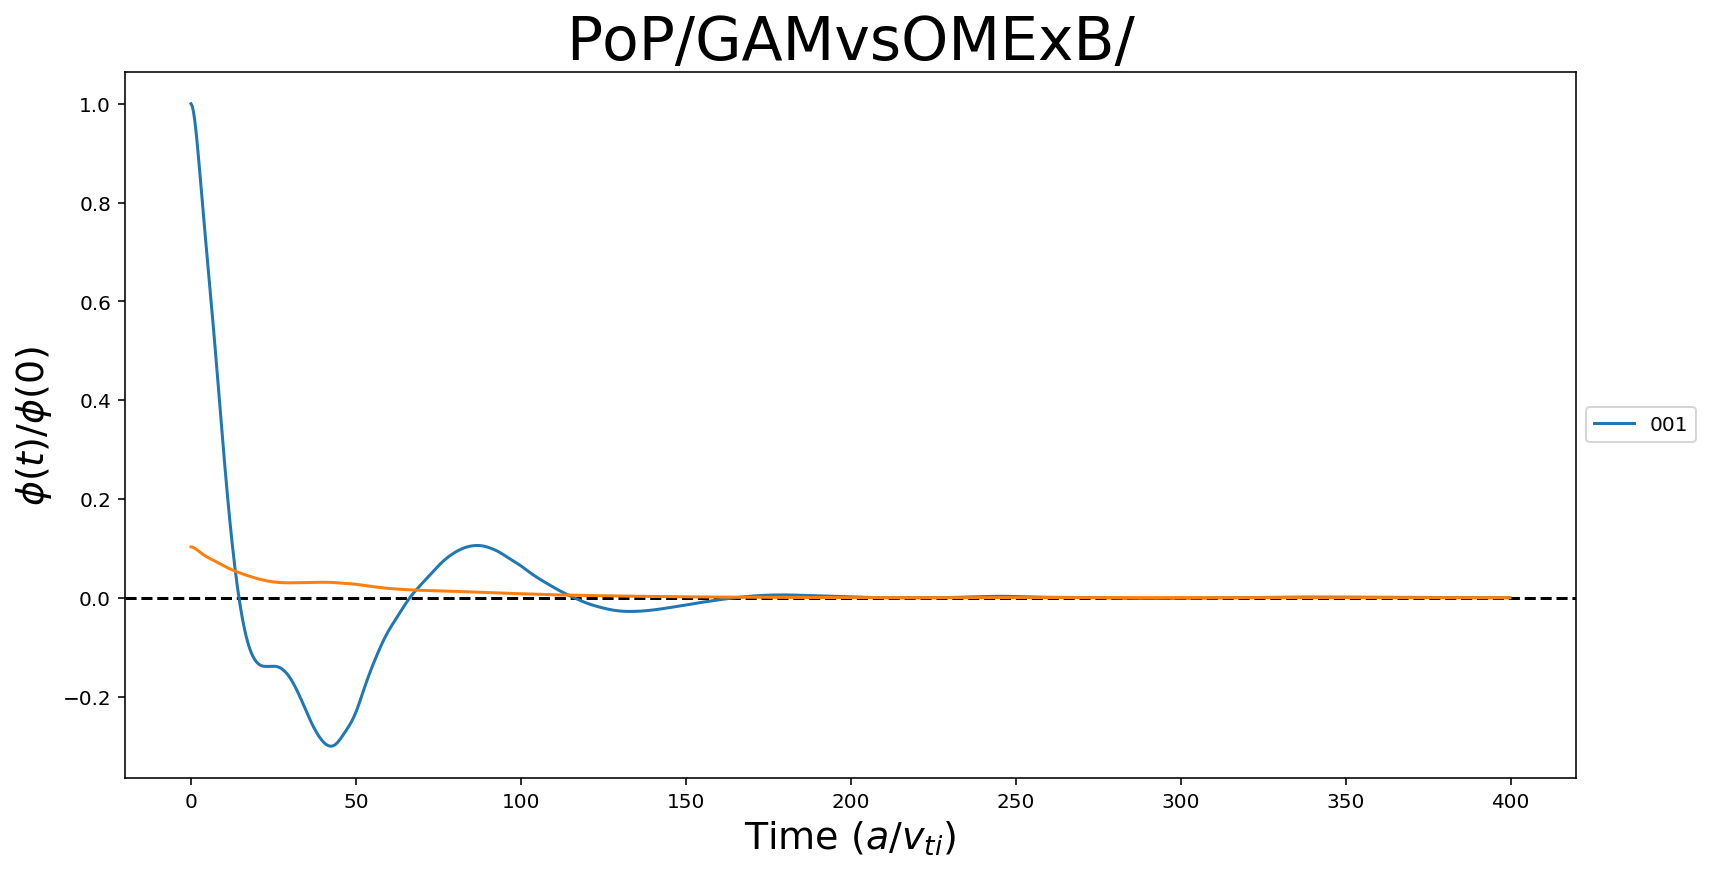

In [65]:
filename = 'PoP/GAMvsOMExB/'
nummy = ['001']
dataset = [('{0}/gamdiagions_0{1}.dat'.format(filename, index), index) for index in nummy]     
datalist = [ ( pylab.loadtxt(datapath), label) for datapath, label in dataset] 
plt.figure(figsize=(13, 6.5))
plt.axhline(y=0, color='black', linestyle='dashed')
plt.title("{0}".format(filename), fontsize=30)
#plt.xscale('log')
plt.xlabel('Time ($a / v_{ti}$)',fontsize=19)
plt.ylabel('$\phi (t) / \phi (0)$',fontsize=19)
for data, label in datalist:
    E = (data[:,1]*(1/data[0, 1]))
    t = data[:,0]
plt.plot(t, E, label='{0}'.format(label))
kx = '0.009'
plt.legend(kx, title='$k_{x}$', fontsize=14)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
intefield = np.trapz(E, t)
rms = np.sqrt(np.mean(E**2))
print(rms, intefield)
dataset = ['PoP/GAMvsOMExB/zonalions_0001.dat']     
midata = [( pylab.loadtxt(datapath)) for datapath in dataset]
for data in midata:
    B = data[:]
plt.plot(t, B, label='{0}'.format(label))
plt.show()

In [33]:
dataset = ['PoP/GAMvsOMExB/zonalions_0001.dat']     
midata = [( pylab.loadtxt(datapath)) for datapath in dataset] 
np.shape(midata)

(1, 1053)

In [63]:
for data in midata:
    E = data[:]

In [64]:
E

array([1.0287e-01, 1.0247e-01, 1.0153e-01, ..., 1.6332e-05, 1.6942e-05,
       1.7540e-05])